This notebook analyzes mutual information scaling for the following scenario.

Let $\mathsf{x}_0 \sim \text{Bernoulli}(0.5)$,
and for $i \geq 1$,
let $\mathsf{x}_i = (\mathsf{x}_0 + \text{Bernoulli}(p)) \, \% \, 2$.

How does
$I(\mathsf{x}_0 \, ; \, \mathsf{x}_1, \ldots, \mathsf{x}_n)$
scale as a function of $n$?

### Load libraries

In [1]:
import scipy.special
import matplotlib.pyplot as plt
import numpy as np

### Helper functions

In [2]:
def bin_entropy(p: float) -> float:
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))


bin_entropy(0.5)


1.0

In [3]:
def x1_to_xn_entropy(p: float, n: int) -> float:
    res = 0

    p = np.longdouble(p)

    for k in range(n + 1):

        # let xs be a binary particular sequence with k zeros
        # what is the probability that we get xs
        prob_particular_seq = (
            p**k * (1 - p) ** (n - k) + p ** (n - k) * (1 - p) ** k
        ) / 2

        # how many such sequences are there?
        num_seqs = np.longdouble(scipy.special.binom(n, k))
        res -= num_seqs * prob_particular_seq * np.log2(prob_particular_seq)

    return res


print(x1_to_xn_entropy(p=0.1, n=50))

24.449779679462276087


In [4]:
def mut_info(p: float, n: int) -> float:
    return x1_to_xn_entropy(p=p, n=n) - n * bin_entropy(p)

print(mut_info(p=0.1, n=50))
print(mut_info(p=0.1, n=58))

0.9999999999982146989
1.0000000000000141918


For p=0.1, we run into some numerical issues at n=58.
Are there better ways of implementing this?

### Inverse binary entropy

In [5]:
# Adapted from https://www.quora.com/What-is-the-inverse-function-of-the-binary-entropy-function-H-p-p-log-p-1-p-log-1-p-restricted-to-the-interval-0-p-frac-1-2
def bern_entropy_deriv(p: float) -> float:
    return np.log2((1 - p) / p)


def inverse_bin_entropy(h: float, n_iters: int = 100) -> float:
    """Newton's method."""
    guess = (np.arcsin((h / np.log2(2)) ** (1 / 0.645))) / np.pi
    for _ in range(n_iters):
        guess = guess + np.nan_to_num(
            (h - bin_entropy(guess)) / bern_entropy_deriv(guess)
        )
    return guess


print(bin_entropy(inverse_bin_entropy(0.42)))
print(bin_entropy(inverse_bin_entropy(1e-6)))

0.42
1e-06


### Scaling laws

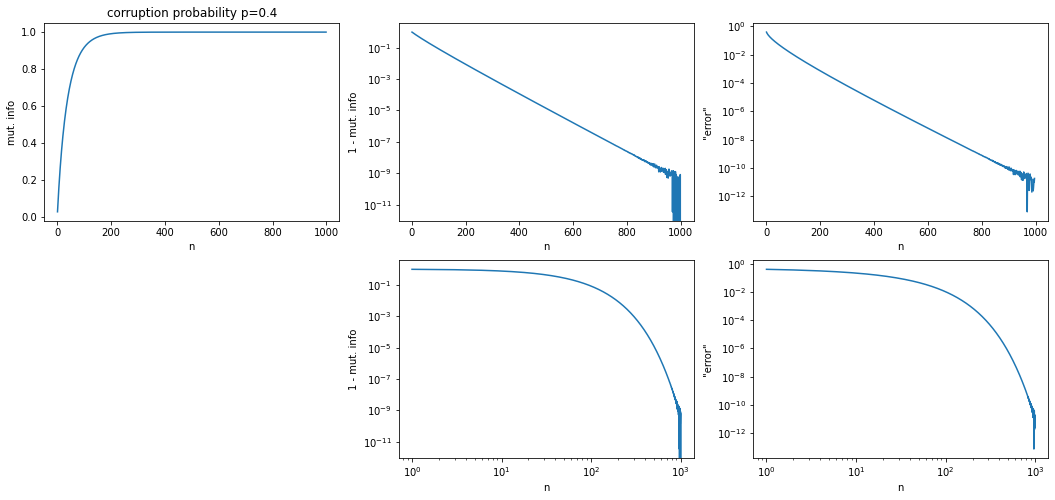

In [6]:
P = 0.4
ns = np.arange(start=1, stop=1000)
infos = np.array([mut_info(p=P, n=n) for n in ns])
errs = np.array([(inverse_bin_entropy(h=1 - i) if i < 1 else np.nan) for i in infos])

plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.plot(ns, infos)
plt.title(f"corruption probability p={P}")
plt.ylabel("mut. info")
plt.xlabel("n")

plt.subplot(2, 3, 2)
plt.plot(ns, 1 - infos)
plt.yscale("log")
plt.ylabel("1 - mut. info")
plt.xlabel("n")
plt.subplot(2, 3, 5)
plt.plot(ns, 1 - infos)
plt.yscale("log"); plt.xscale("log")
plt.ylabel("1 - mut. info")
plt.xlabel("n")

plt.subplot(2, 3, 3)
plt.plot(ns, errs)
plt.yscale("log")
plt.ylabel("\"error\"")
plt.xlabel("n")
plt.subplot(2, 3, 6)
plt.plot(ns, errs)
plt.yscale("log"); plt.xscale("log")
plt.ylabel("\"error\"")
plt.xlabel("n");

Note that
$H(\mathsf{x}_0 \, | \, \mathsf{x}_1, \ldots, \mathsf{x}_n)$
decays *exponentially* in $n$.
So this scales better than any power law!

Let $H_b(p) = - p \log p - (1 - p) \log (1 - p)$
be the binary entropy function.

We can convert $H(\mathsf{x}_0 \, | \, \mathsf{x}_1, \ldots, \mathsf{x}_n)$
into an "error" scale by applying the inverse binary entropy function
$H_b^{-1}$, which outputs values in $[0, 0.5]$.

Even on an error scale, we still get better than power law scaling!